In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler, Imputer, LabelEncoder
from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import TSNE

import seaborn as sns

%matplotlib inline

In [64]:
dataset = pd.read_csv("../data/processed/3/dataset.csv.gz", index_col="MUTANT")
dataset = dataset[dataset.TYPE != "Unclassified"]
feat_cols = dataset.drop("TYPE", 1).columns

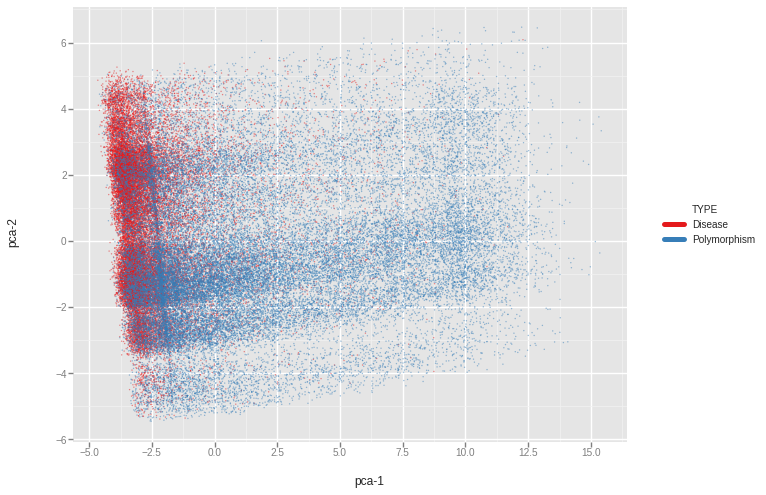

In [65]:
model = Pipeline([
    ('imputer', Imputer(missing_values="NaN", strategy="median")),
    ('scaler', StandardScaler()),
    ('pca', PCA())
])

pca_result = model.fit_transform(dataset[feat_cols].values)


dataset['pca-1'] = pca_result[:,0]
dataset['pca-2'] = pca_result[:,1] 
dataset['pca-3'] = pca_result[:,2] 
dataset['pca-4'] = pca_result[:,3] 


from ggplot import *

chart = ggplot(dataset, aes(x='pca-1', y='pca-2', color='TYPE') ) \
        + geom_point(size=2,alpha=0.5) \
        + scale_color_brewer(type = 'qual', palette = 'Set1') 
        
chart.save(filename="../documents/latex/figures/2/pca_1.pdf")

In [41]:
pd.DataFrame(model.steps[2][1].components_[0:2],columns=dataset[feat_cols].columns,index = ['PC-1','PC-2']).transpose()


,PC-1,PC-2
ENTROPY,0.203332,-0.324066
REL_ENTROPY,-0.162903,0.463332
PHC_A,-0.190073,0.108063
PHC_C,-0.198004,-0.173913
PHC_D,-0.193947,-0.108597
PHC_E,-0.192993,-0.088835
PHC_F,-0.208439,-0.137956
PHC_G,-0.172206,-0.001098
PHC_H,-0.206866,-0.129337
PHC_I,-0.196148,-0.055202


In [30]:
model.steps[2][1].components_[1]

array([-0.3240658 ,  0.4633324 ,  0.10806286, -0.17391282, -0.1085969 ,
       -0.08883545, -0.1379556 , -0.00109801, -0.12933659, -0.05520242,
       -0.07466185, -0.0006178 , -0.12354574, -0.08481568, -0.04008655,
       -0.09906149, -0.1410036 ,  0.07971131,  0.0550073 ,  0.02417633,
       -0.18486224, -0.17839866, -0.06267275,  0.06188855,  0.39263361,
        0.44085803, -0.08077877,  0.08823803, -0.16076122, -0.12276719,
       -0.13556423, -0.11886805,  0.01674293, -0.00255249,  0.00994333,
       -0.01367216, -0.00272744])

In [25]:
model.steps[2][1].explained_variance_ratio_[0:3]

array([ 0.45167463,  0.038726  ,  0.03388048])

In [15]:
dataset.ix[subset,:].TYPE.value_counts()

Polymorphism    275
Disease         225
Name: TYPE, dtype: int64

Perplexity: 75
t-SNE done! Time elapsed: 6.464331150054932 seconds


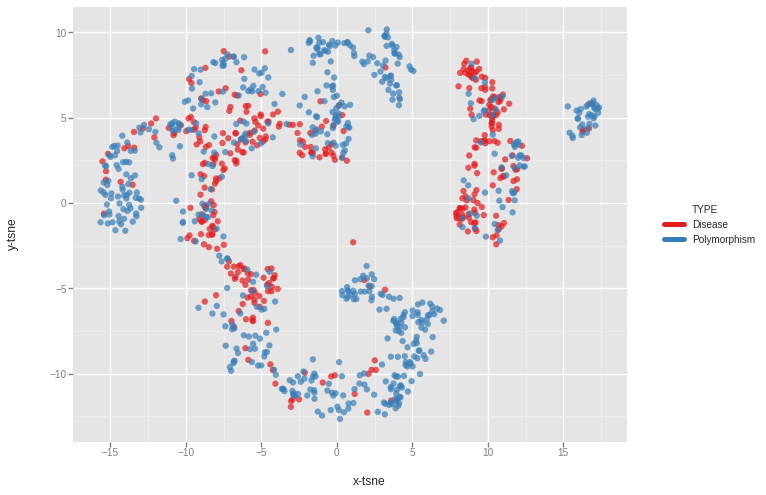

<ggplot: (8749142017821)>

In [66]:
import time

n_sne = 1000
rndperm = np.random.permutation(dataset.shape[0])
subset = rndperm[:n_sne]
perplexities = [75]
RANDOM_STATE = 75

for p in perplexities:
    print("Perplexity: {}".format(p))
    time_start = time.time()
    model = Pipeline([
        ('imputer', Imputer(missing_values="NaN", strategy="median")), 
        ('scaler', StandardScaler()),
        ('tsne', TSNE(n_components=2, verbose=0, perplexity=p, n_iter=500, random_state=RANDOM_STATE))
    ])
    
    tsne_results = model.fit_transform(dataset.ix[subset,"pca-1":"pca-2"].values)
    
    print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

    df_tsne = dataset.ix[subset,:].copy()
    df_tsne['x-tsne'] = tsne_results[:,0]
    df_tsne['y-tsne'] = tsne_results[:,1]

    chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='TYPE') ) \
            + geom_point(size=40,alpha=0.7) \
            + scale_color_brewer(type = 'qual', palette = 'Set1')

#     chart.save(filename="/home/marlan/Desktop/perplexity_{}.jpg".format(p))
chart

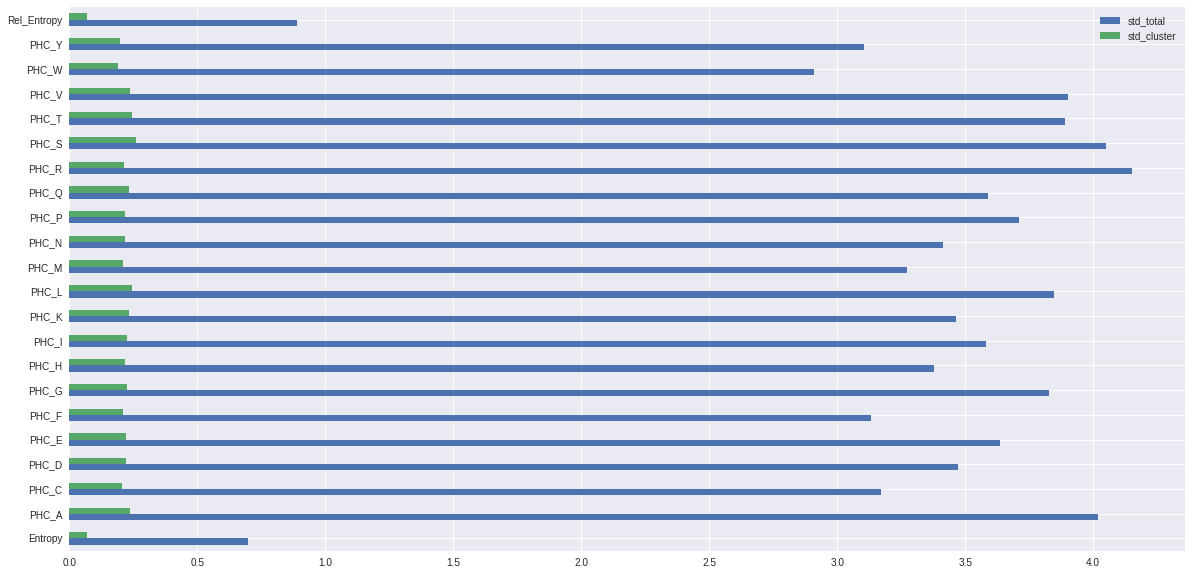

In [84]:
genomic_msa = pd.read_csv("../data/external/snvbox_features/genomic_msa_features.csv").drop_duplicates()
counts = genomic_msa.groupby(["UID", "Pos"]).size().reset_index(name='counts')
counts = counts[counts.counts > 1]
std_total = genomic_msa.describe().loc["std"].rename("std_total")
std_clusters = genomic_msa.groupby(["UID", "Pos"]).std().fillna(0).merge(counts, left_index=True, right_on=["UID", "Pos"]).describe().loc["mean"].rename("std_cluster")
pd.concat([std_total, std_clusters], axis=1).drop(["counts", "Pos", "PHC_sum", "PHC_squaresum"]).plot(kind='barh', figsize=(20, 10))

In [ ]:
model = Pipeline([
('imputer', Imputer(missing_values="NaN", strategy="median")), 
('tsne', TSNE(n_components=2, verbose=0, perplexity=p, n_iter=1000))
])

tsne_results = model.fit_transform(dataset.ix[subset,feat_cols].values)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

df_tsne = dataset.ix[subset,:].copy()
df_tsne['x-tsne'] = tsne_results[:,0]
df_tsne['y-tsne'] = tsne_results[:,1]

chart = ggplot(df_tsne, aes(x='x-tsne', y='y-tsne', color='TYPE') ) \
        + geom_point(size=15,alpha=0.5) \
        + scale_color_brewer(type = 'qual', palette = 'Set1')
chart.save(filename="/home/marlan/Desktop/perplexity_{}.jpg".format(p))